In [4]:
# this code is based on https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN, which is released under the MIT licesne

import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import os
import random

from math import log2
from datetime import datetime
from tqdm import tqdm
from numpy import asarray
from numpy.random import randn
from numpy import linspace

batch_size  = 32 # for displaying a sample of dataset images
dataset = 'celeba'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

START_TRAIN_AT_IMG_SIZE = 4
LEARNING_RATE = 1e-3
BATCH_SIZES = [512, 256, 128, 64, 30]  # change these depending on RAM
CHANNELS_IMG = 3
IMAGE_SIZE = 64 #128
Z_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
NUM_STEPS = int(log2(IMAGE_SIZE/4)) + 1

PROGRESSIVE_EPOCHS = [15,25,25,25,12]

FIXED_NOISE = torch.randn(16, Z_DIM, 1, 1).to(DEVICE)
NUM_WORKERS = 4

In [5]:
# FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmarks = True

seed_everything(42)

In [6]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize(128)
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

if dataset == 'lsun':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.LSUN('drive/My Drive/training/lsun', transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['church_outdoor_train']

if dataset == 'ffhq':
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./thumbnails128x128', transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize(64)
        ])), batch_size=batch_size, shuffle=True)

if dataset == 'celeba_hq':
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./calebhq_train', transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize(64)
        ])), batch_size=batch_size, shuffle=True)

if dataset == 'celeba':
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./img_align_celeba_root', transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize(64)
        ])), batch_size=batch_size, shuffle=True)
    
train_iterator = iter(cycle(train_loader))


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


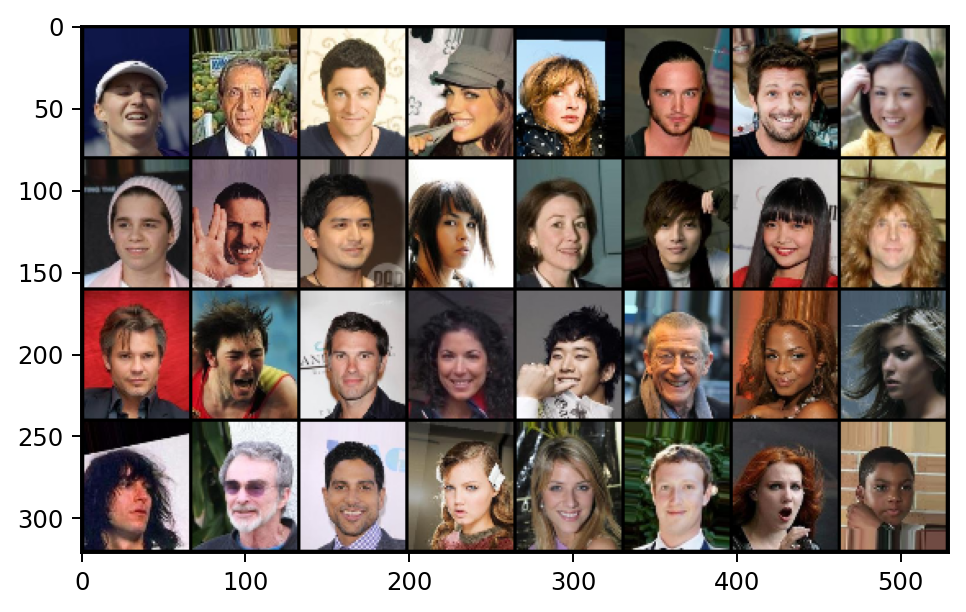

In [7]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(DEVICE), t.to(DEVICE)
print(t)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Main training loop**

In [9]:
# FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN/model.py

"""
Implementation of ProGAN generator and discriminator with the key
attributions from the paper. We have tried to make the implementation
compact but a goal is also to keep it readable and understandable.
Specifically the key points implemented are:

1) Progressive growing (of model and layers)
2) Minibatch std on Discriminator
3) Normalization with PixelNorm
4) Equalized Learning Rate (here I cheated and only did it on Conv layers)
"""

"""
Factors is used in Discrmininator and Generator for how much
the channels should be multiplied and expanded for each layer,
so specifically the first 5 layers the channels stay the same,
whereas when we increase the img_size (towards the later layers)
we decrease the number of chanels by 1/2, 1/4, etc.
"""
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i]) # in channels
            conv_out_c = int(in_channels * factors[i + 1]) # out channels
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    # steps is how many progressive blocks to run it through steps=0 (4x4), steps=1 (8x8), ...
    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [11]:
# FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN

def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    
#     print(real.shape)
#     print(fake.shape)
#     print(beta.shape)
    
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [12]:
# ADAPTED FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN

def get_loader(image_size):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((image_size, image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    if dataset == 'celeba_hq':
        dataset_folder = torchvision.datasets.ImageFolder('./calebhq_train', transform=transform)
    if dataset == 'ffhq':
        dataset_folder = torchvision.datasets.ImageFolder('./thumbnails128x128', transform=transform)
    if dataset == 'celeba':
        dataset_folder = torchvision.datasets.ImageFolder('./img_align_celeba_root', transform=transform)
    loader = torch.utils.data.DataLoader(
        dataset_folder,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    return loader, dataset

In [18]:
# ADAPTED FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN

def run(
    start_img_size=START_TRAIN_AT_IMG_SIZE,
    save_file_name="progan_checkpoint",
    epoch_lens=PROGRESSIVE_EPOCHS,
    load_from_checkpoint=False,
    load_file_name="progan_checkpoint",
    load_from_epoch=1,
    save_every_epoch=1,
    save_at_size=64
):
    """Run PGGAN training
    parameters:
    start_img_size: int - Image size to start from e.g. 4,8,16,...
    save_file_name: Folder name to save model parameters in 
    epoch_lens: [int] - array of epoch sizes for each image size starting from 4x4
    load_from_checkpoint: boolean - Load in pretrained model parameters - use load_file_name and load_from_epoch
    load_file_name: string - name of folder to load model parameters from
    load_from_epoch: epoch number to load model parameters from (this is name of file e.g. ../progam_checkpoint/1.chkpt).
    save_every_epoch: int - number of epochs between each save 
    """
    gen = Generator(
            Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
        ).to(DEVICE)
    critic = Discriminator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)

    # initialise the optimiser
    opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
    print('Optimisers have been created!')

    if load_from_checkpoint:
        params = torch.load(f'drive/My Drive/training/{load_file_name}/{load_from_epoch}.chkpt')
        gen.load_state_dict(params['gen'])
        critic.load_state_dict(params['critic'])
        opt_gen.load_state_dict(params['opt_gen'])
        opt_critic.load_state_dict(params['opt_critic'])


    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()


    gen.train()
    critic.train()
    
    step = int(log2(start_img_size / 4))
    for num_epochs in epoch_lens[step:]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
                print(f"Epoch [{epoch+1}/{num_epochs}]")

                gen_loss_arr = []
                crit_loss_arr = []

                for i, batch in enumerate(loader):

                    real, t = batch
                    real, t = real.to(DEVICE), t.to(DEVICE)

                    # train discriminator 
                    # random noise passed into generator to create fake image
                    cur_batch_size =  real.size(0)


                    noise = torch.randn(cur_batch_size, Z_DIM,1,1).to(DEVICE)
                    with torch.cuda.amp.autocast():
                        fake = gen(noise, alpha, step)
                        critic_real = critic(real, alpha, step)#.reshape(-1)
                        critic_fake = critic(fake.detach(), alpha, step)#.reshape(-1)
                        # gradient penalty
                        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
                        loss_critic = (
                            -(torch.mean(critic_real) - torch.mean(critic_fake))
                            + LAMBDA_GP * gp
                            + (0.001 * torch.mean(critic_real ** 2)) # e_drift = 0.001
                        )


                    opt_critic.zero_grad()
                    scaler_critic.scale(loss_critic).backward()
                    scaler_critic.step(opt_critic)
                    scaler_critic.update()

                    # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
                    with torch.cuda.amp.autocast():
                        gen_fake = critic(fake, alpha, step)
                        loss_gen = -torch.mean(gen_fake)

                    opt_gen.zero_grad()
                    scaler_gen.scale(loss_gen).backward()
                    scaler_gen.step(opt_gen)
                    scaler_gen.update()

                    # Update alpha and ensure less than 1
                    alpha += cur_batch_size / (
                        (epoch_lens[step] * 0.5) * len(dataset)
                    )
                    alpha = min(alpha, 1)


                    gen_loss_arr = np.append(gen_loss_arr, loss_gen.item())
                    crit_loss_arr = np.append(crit_loss_arr, loss_critic.item())

                    if not((i+1) % 50):
                        print(f'Epoch:{epoch+1} Batch:{i+1}')
                        if real.size(3) == save_at_size:
                            
                            if ((epoch+1)%save_every_epoch) == 0:
                                if not os.path.exists(f'drive/My Drive/training/{save_file_name}'):
                                    os.makedirs(f'drive/My Drive/training/{save_file_name}')

                                torch.save({
                                    'gen':gen.state_dict(),
                                    'critic':critic.state_dict(),
                                    'opt_gen':opt_gen.state_dict(),
                                    'opt_critic':opt_critic.state_dict(),
                                }, f'drive/My Drive/training/{save_file_name}/{epoch+1}.chkpt')

                print('loss D: {:.3f}, loss G: {:.3f}'.format(gen_loss_arr.mean(), crit_loss_arr.mean()))

                with torch.cuda.amp.autocast():
                    g = gen(FIXED_NOISE, 1, step)
                    
                    g = g*0.5+0.5
                plt.imshow(torchvision.utils.make_grid(g).cpu().data.clamp(0,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
                plt.show()
        step += 1 # progress to next image

#### The model was trained incrementally using the commented 'run' calls below due to 24-hour limit of NCC. The uncommented 'run' call will train the model from 4x4 images to 64x64 in one go if there is no time limit.

In [34]:
## Train on 4x4
# run(
#     start_img_size=4,
#     save_file_name="progan_checkpoint_lf_512_4",
#     epoch_lens=[15],
#     save_every_epoch=5,
#     save_at_size=4,
# )

## Train on 8x8
# run(
#     start_img_size=8,
#     save_file_name="progan_checkpoint_lf_512_8",
#     epoch_lens=[0, 25],
#     load_from_checkpoint=True,
#     load_file_name="progan_checkpoint_lf_512_4",
#     load_from_epoch=15,
#     save_every_epoch=5,
#     save_at_size=8,
# )

In [ ]:
# ## Train on 16x16
# run(
#     start_img_size=16,
#     save_file_name="progan_checkpoint_lf_512_16",
#     epoch_lens=[0, 0, 25],
#     load_from_checkpoint=True,
#     load_file_name="progan_checkpoint_lf_512_8",
#     load_from_epoch=25,
#     save_every_epoch=5,
#     save_at_size=16,
# )

In [ ]:
# ## Train on 32x32
# run(
#     start_img_size=32,
#     save_file_name="progan_checkpoint_lf_512_32",
#     epoch_lens=[0, 0, 0, 15],
#     load_from_checkpoint=True,
#     load_file_name="progan_checkpoint_lf_512_16",
#     load_from_epoch=25,
#     save_every_epoch=5,
#     save_at_size=32,
# )

In [ ]:
# ## Train on 32x32
# run(
#     start_img_size=32,
#     save_file_name="progan_checkpoint_lf_512_32_2",
#     epoch_lens=[0, 0, 0, 10],
#     load_from_checkpoint=True,
#     load_file_name="progan_checkpoint_lf_512_32",
#     load_from_epoch=15,
#     save_every_epoch=5,
#     save_at_size=32,
# )

In [ ]:
# # ## Train on 64x64
# run(
#     start_img_size=64,
#     save_file_name="progan_checkpoint_lf_512_64",
#     epoch_lens=[0, 0, 0, 0, 10],
#     load_from_checkpoint=True,
#     load_file_name="progan_checkpoint_lf_512_32_2",
#     load_from_epoch=10,
#     save_every_epoch=1,
#     save_at_size=64,
# )

Optimisers have been created!
Current image size: 64
Epoch [1/10]
Epoch:1 Batch:50
Epoch:1 Batch:100
Epoch:1 Batch:150
Epoch:1 Batch:200
Epoch:1 Batch:250
Epoch:1 Batch:300
Epoch:1 Batch:350
Epoch:1 Batch:400
Epoch:1 Batch:450
Epoch:1 Batch:500
Epoch:1 Batch:550
Epoch:1 Batch:600
Epoch:1 Batch:650
Epoch:1 Batch:700
Epoch:1 Batch:750
Epoch:1 Batch:800
Epoch:1 Batch:850
Epoch:1 Batch:900
Epoch:1 Batch:950
Epoch:1 Batch:1000
Epoch:1 Batch:1050
Epoch:1 Batch:1100
Epoch:1 Batch:1150
Epoch:1 Batch:1200
Epoch:1 Batch:1250
Epoch:1 Batch:1300
Epoch:1 Batch:1350
Epoch:1 Batch:1400
Epoch:1 Batch:1450
Epoch:1 Batch:1500
Epoch:1 Batch:1550
Epoch:1 Batch:1600
Epoch:1 Batch:1650
Epoch:1 Batch:1700
Epoch:1 Batch:1750
Epoch:1 Batch:1800
Epoch:1 Batch:1850
Epoch:1 Batch:1900
Epoch:1 Batch:1950
Epoch:1 Batch:2000
Epoch:1 Batch:2050
Epoch:1 Batch:2100
Epoch:1 Batch:2150
Epoch:1 Batch:2200
Epoch:1 Batch:2250
Epoch:1 Batch:2300
Epoch:1 Batch:2350
Epoch:1 Batch:2400
Epoch:1 Batch:2450
Epoch:1 Batch:2500
Epoc

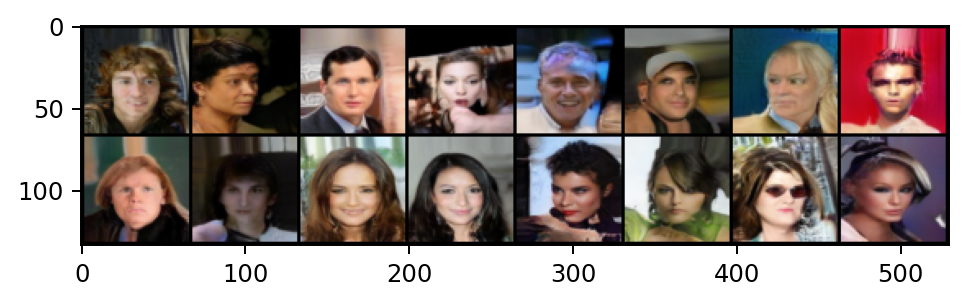

Epoch [2/10]


RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

In [28]:
# # ## Train on 64x64
# run(
#     start_img_size=64,
#     save_file_name="progan_checkpoint_lf_512_64_3",
#     epoch_lens=[0, 0, 0, 0, 2],
#     load_from_checkpoint=True,
#     load_file_name="progan_checkpoint_lf_512_64_2",
#     load_from_epoch=1,
#     save_every_epoch=1,
#     save_at_size=64,
# )

In [ ]:
run(
    start_img_size=4,
    save_file_name="progan_checkpoint",
    epoch_lens=PROGRESSIVE_EPOCHS,
    load_from_checkpoint=False,
    save_every_epoch=1,
    save_at_size=64,
)

In [27]:
def get_best_64_gen():
    gen = Generator(
            Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
        ).to(DEVICE)    
    params = torch.load(f'drive/My Drive/training/progan_checkpoint_lf_512_64_3/1.chkpt')
    gen.load_state_dict(params['gen'])
    return gen

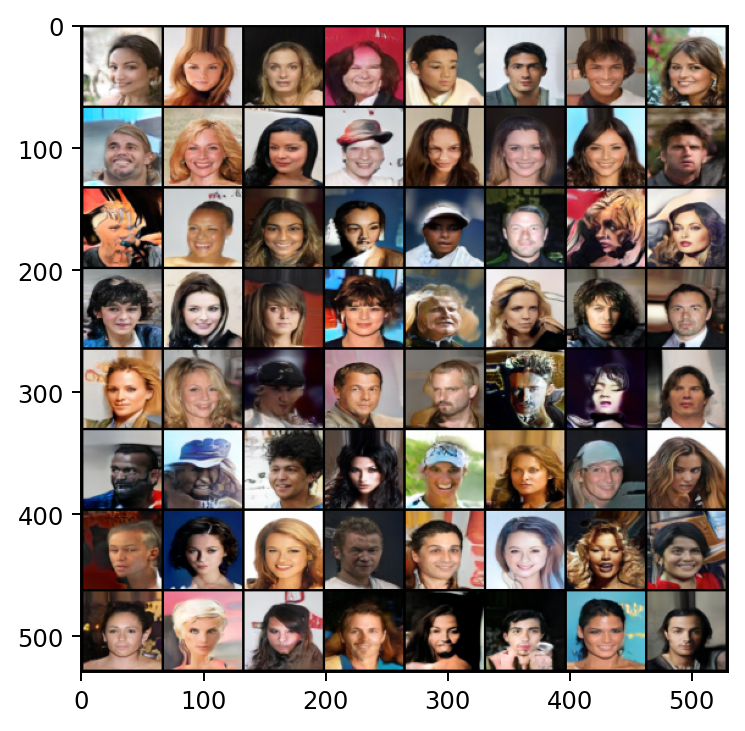

In [95]:
def gen_examples_64():
    gen = get_best_64_gen()
    
    with torch.cuda.amp.autocast():
        noise = torch.randn(64, Z_DIM,1,1).to(DEVICE)
        g = gen(noise, 1, 4)
                    
        g = g*0.5+0.5
        plt.imshow(torchvision.utils.make_grid(g).cpu().data.clamp(0,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
        plt.show()
gen_examples_64() 

In [ ]:
def interpolate_points(p1, p2, n_steps=10):
    # from https://www.kaggle.com/code/kvsnoufal/faceautoencoder-model2/notebook
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

def generate_interpolations(n):
    interpolations = None
    gen = get_best_64_gen()
    for _ in range(n):
        interpolated = torch.Tensor().to(DEVICE)

        noise_dim = 512
        i = torch.Tensor(interpolate_points(
            np.random.randn(noise_dim).reshape(1, noise_dim),
            np.random.randn(noise_dim).reshape(1, noise_dim)
        )).to(DEVICE)


        interpolated = torch.cat((interpolated, i))

        interpolated = interpolated.reshape(10, noise_dim, 1, 1)

        imgs = gen(interpolated, 1, 4)
        imgs = imgs*0.5+0.5
        if interpolations is None:
            interpolations = imgs
        else:
            interpolations = torch.cat((interpolations, imgs), 0)
    plt.rcParams["figure.dpi"] = 175

    plt.imshow(
        torchvision.utils.make_grid(interpolations, nrow=10)#, normalize=True)
        .cpu()
        .data.permute(0, 2, 1)
        .contiguous()
        .permute(2, 1, 0),
        cmap=plt.cm.binary,
    )

    plt.show()

for _ in range(1):
    generate_interpolations(8)